# Knot Crossing Counter

This notebook trains and evaluates neural networks to count crossings in images of mathematical knots.

## Environment Setup

In [ ]:
# Uncomment if running in new environment
# !pip install torch torchvision
# !pip install matplotlib numpy pillow

In [ ]:
!pip install cairosvg

In [ ]:
# Source: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
import torch
from torchvision.transforms import v2

import numpy as np
import math
import random
import matplotlib.pyplot as plt

import shutil
import zipfile
import glob

import os
import os.path
import sys
from pathlib import Path

import urllib.request
import requests
from requests.structures import CaseInsensitiveDict

import tqdm
from tqdm.notebook import tqdm as tqdmn

from torchvision.datasets import VisionDataset
from torch.utils.data import random_split, DataLoader

import skimage as ski
import cairosvg
from PIL import Image
import PIL.ImageOps
from skimage.morphology import skeletonize
from skimage.transform import resize
from skimage.util import invert

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.distributed.xla_multiprocessing as xmp
from torch_xla.distributed.parallel_loader import MpDeviceLoader

import gc
import time

import helper_functions

## Constants and Globals

In [ ]:
RESIZE_SIZE = 512 # This is final image size, which we use in models

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 2
PIN_MEMORY = True

In [ ]:
device = xm.xla_device()

## Helper Functions

In [ ]:
# The following function checks if two tuples are in a given epsilon neighbourhood of each other
def is_in_neighbourhood(x: tuple, y: tuple, epsilon: tuple):
  for i in range(len(x)):
    if (abs(x[i] - y[i]) > epsilon[i]):
      return False
  return True

In [ ]:
# Function for directory preparation and file utilities
def reset_dir(dir_name):
  shutil.rmtree(dir_name, ignore_error=True)
  os.makedirs(dir_name, exist_ok=True)

In [ ]:
# Function for calculating accuracy between truth labels and predictions
from helper_functions import accuracy_fn

## Data Loading

_This section will contain code to load and inspect the dataset._

### Constants and Globals

In [ ]:
DIR_PROCESSED = "../data/content/saved_knots/" # directory for processed knots (skeletonize + resize)

In [ ]:
create_dir(DIR_PROCESSED)

### From prideout; train data

_Source: https://prideout.net/blog/svg_knots/_

#### Constants and Globals

In [ ]:
IMG_SIZE = 4096 # Initial size for images from https://prideout.net/blog/svg_knots/

FILTER_COLOR = (50, 50, 50) # color used for filter the images
TARGET_COLOR = (0, 0, 0) # target color for knots
BG_COLOR = (255, 255, 255) # background color in knots' images

E_TARGET = (60, 60, 60) # boundary color, so we treat to all colors less than E_TARGET as to target color

knots_count_1 = [1, 0, 0, 1, 1, 2, 3, 7, 21, 49, 3] # number of knots with i crossings represented on the https://prideout.net/blog/svg_knots/knottable_v1.svg

In [ ]:
DIR_INST = "../data/content/new_knots_svg/" # directory for installed knots in .svg
DIR_CONV = "../data/content/new_knots_png/" # directory for converted installed knots in .png

#### Directories

In [ ]:
reset_dir(DIR_INST)
reset_dir(DIR_CONV)

#### Installation and Preprocessing

In [ ]:
for cross_num in range(len(knots_count_1)):
  for i in range(knots_count_1[cross_num]):
    url = f"https://prideout.net/blog/svg_knots/knots/{cross_num}_{i+1}.svg" # url adress for knot on prideout.net
    svg_path = DIR_INST + f"{cross_num}_{i+1}.svg" # path for save .svg knots
    urllib.request.urlretrieve(url, svg_path)

    # Convert .svg to .png and save
    png_path = DIR_CONV + f"{cross_num}_{i+1}.png" # path for save .png knots
    cairosvg.svg2png(bytestring=open(svg_path, 'rb').read(), write_to=png_path, output_width=IMG_SIZE, output_height=IMG_SIZE)

    # all .svg files contain only knot without background
    # so we add white background to images
    bg = Image.new("RGB", (IMG_SIZE, IMG_SIZE), "WHITE")
    fg = Image.open(png_path)
    bg.paste(fg, (0, 0), fg)
    bg.save(png_path)

    # clear the image of errors
    pixels_bg = bg.load()
    img = Image.new(bg.mode, bg.size)
    pixels = img.load()
    for x in range(IMG_SIZE):
      for y in range(IMG_SIZE):
        if is_in_neighbourhood(pixels_bg[x, y], TARGET_COLOR, E_TARGET):
          pixels[x, y] = TARGET_COLOR
        else:
          pixels[x, y] = BG_COLOR
    img.save(png_path)

    # Processing images: skeletonize + grayscale
    img = Image.open(png_path).convert('L')
    image = np.array(img)
    image = invert(image).astype(int)
    skeleton = skeletonize(image).astype(int)
    skeleton = resize(skeleton, (RESIZE_SIZE, RESIZE_SIZE))

    plt.imsave(png_path, skeleton, cmap='Greys')

In [ ]:
# clear used directories
shutil.rmtree(svg_path)

### From github - dow we need to write a code for downloading?

_Source: https://github.com/annedranowski/knot-cnn/tree/main/data/raw_

#### Constants and Globals

In [ ]:
GIT_TOKEN = "" # insert your token; requires full repo list marked while creating

GH_PREFIX = "https://raw.githubusercontent.com"
ORG = "annedranowski"
REPO = "knot-cnn"
BRANCH = "main"
FOLDER = "data/raw"

SAVE_DIR = ""

knots_count_2 = [1, 1, 2, 3, 7, 21, 49, 165, 552, 2176, 9988, 46972, 253293, 1388705, 8053393, 48266466, 294130458] # number of knots with i crossings represented on the github

In [ ]:
DIR_INST = "../data/content/new_knots_svg/" # directory for installed knots in .svg
DIR_CONV = "../data/content/new_knots_png/" # directory for converted installed knots in .png

#### Directories

In [ ]:
reset_dir(DIR_INST)
reset_dir(DIR_CONV)

#### Installation and Preprocessing

In [ ]:
for cross_num in range(len(knots_count_1)):
  for i in range(knots_count_1[cross_num]):
    url = f"https://prideout.net/blog/svg_knots/knots/{cross_num}_{i+1}.svg" # url adress for knot on prideout.net
    svg_path = DIR_INST + f"{cross_num}_{i+1}.svg" # path for save .svg knots
    urllib.request.urlretrieve(url, svg_path)

    # Convert .svg to .png and save
    png_path = DIR_CONV + f"{cross_num}_{i+1}.png" # path for save .png knots
    cairosvg.svg2png(bytestring=open(svg_path, 'rb').read(), write_to=png_path, output_width=IMG_SIZE, output_height=IMG_SIZE)

    # all .svg files contain only knot without background
    # so we add white background to images
    bg = Image.new("RGB", (IMG_SIZE, IMG_SIZE), "WHITE")
    fg = Image.open(png_path)
    bg.paste(fg, (0, 0), fg)
    bg.save(png_path)

    # clear the image of errors
    pixels_bg = bg.load()
    img = Image.new(bg.mode, bg.size)
    pixels = img.load()
    for x in range(IMG_SIZE):
      for y in range(IMG_SIZE):
        if is_in_neighbourhood(pixels_bg[x, y], TARGET_COLOR, E_TARGET):
          pixels[x, y] = TARGET_COLOR
        else:
          pixels[x, y] = BG_COLOR
    img.save(png_path)

    # Processing images: skeletonize + grayscale
    img = Image.open(png_path).convert('L')
    image = np.array(img)
    image = invert(image).astype(int)
    skeleton = skeletonize(image).astype(int)
    skeleton = resize(skeleton, (RESIZE_SIZE, RESIZE_SIZE))

    plt.imsave(png_path, skeleton, cmap='Greys')

In [ ]:
# clear used directories
shutil.rmtree(svg_path)

## Preprocessing and Transformations

### Constants and Globals

In [ ]:
TRAIN_TEST_SPLIT = 0.8 # Used in splitting dataset into train and test parts

### Custom Dataset Class

In [ ]:
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def has_file_allowed_extension(filename, extensions):
  return filename.lower().endswith(extensions)


def is_image_file(filename):
  return has_file_allowed_extension(filename, IMG_EXTENSIONS)


def make_dataset(dir, class_to_idx, extensions=None, is_valid_file=None):
  images = []
  dir = os.path.expanduser(dir)
  if not ((extensions is None) ^ (is_valid_file is None)):
    raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
  if extensions is not None:
    def is_valid_file(x):
      return has_file_allowed_extension(x, extensions)
  for target in sorted(class_to_idx.keys()):
    d = os.path.join(dir, target)
    if not os.path.isdir(d):
      continue
    for root, _, fnames in sorted(os.walk(d)):
      for fname in sorted(fnames):
        path = os.path.join(root, fname)
        if is_valid_file(path):
          item = (path, class_to_idx[target])
          images.append(item)

  return images

def pil_loader(path):
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')

class CustomDatasetFolder(VisionDataset):
  def __init__(self, root, loader, extensions=None, transform=None,
               target_transform=None, is_valid_file=None):
    super().__init__(root, transform=transform,
                     target_transform=target_transform)
    classes, class_to_idx = self._find_classes(self.root)
    samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file)
    if len(samples) == 0:
        raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                            "Supported extensions are: " + ",".join(extensions)))

    self.loader = loader
    self.extensions = extensions

    self.classes = classes
    self.class_to_idx = class_to_idx
    self.samples = samples
    self.targets = [s[1] for s in samples]

  def _find_classes(self, dir):
    if sys.version_info >= (3, 5):
        # Faster and available in Python 3.5 and above
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    else:
        classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()

    classes = [int(i) for i in classes]
    classes = [str(i) for i in range(0, max(classes)+1)]

    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

  def __getitem__(self, index):
    path, target = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
        sample = self.transform(sample)
    if self.target_transform is not None:
        target = self.target_transform(target)

    return sample, target

  def __len__(self):
    return len(self.samples)

class CustomImageFolder(CustomDatasetFolder):
  def __init__(self, root, transform=None, target_transform=None,
               loader=pil_loader, is_valid_file=None):
    super().__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
    self.imgs = self.samples

### Train/Test Datasets & Dataloaders Definitions

#### Datasets

In [ ]:
# Main dataset

data_transform = v2.Compose([v2.Grayscale(num_output_channels=1),
                             v2.ToImage(),
                             v2.ToDtype(torch.float32, scale=True),
                             v2.functional.invert,
                             ])

data = CustomImageFolder(root='/content/saved_knots',
                         transform=data_transform)

In [ ]:
train_data, valid_data = random_split(data, [TRAIN_TEST_SPLIT, 1-TRAIN_TEST_SPLIT])

#### Dataloaders

In [ ]:
train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

valid_dataloader = DataLoader(valid_data,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY)

## Model Definition

## Training Loop

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch_xla.distributed.parallel_loader.MpDeviceLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: helper_functions):
    train_loss, train_acc = 0, 0
    y_pred_train, y_target_train = [], []
    times_epoch = []

    optimizer.zero_grad()
    for i, (X, y) in enumerate(tqdmn(data_loader)):
        start = time.time()

        X, y = X.to(device).to(X.dtype), y.to(device).to(y.dtype)

        y_pred = model(X).squeeze(dim=1)

        for i in y_pred.detach().cpu().tolist():
          y_pred_train.append(round(i))
        for i in y.detach().cpu().tolist():
          y_target_train.append(round(i))

        loss = loss_fn(y_pred, y.type(torch.float32))
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.round())

        loss.backward()

        if (i+1) % (BATCH_SIZE//8) == 0:
          xm.optimizer_step(optimizer)
          optimizer.zero_grad()

        times_epoch.append(time.time()-start)

        xm.mark_step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print("\nTrain loss: {:.5f} | Train accuracy: {:.2f}%".format(train_loss, train_acc))

    del y_pred, loss
    return y_pred_train, y_target_train, train_loss.detach().cpu().numpy(), train_acc, times_epoch

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch_xla.distributed.parallel_loader.MpDeviceLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: helper_functions,
              scheduler: torch.optim.lr_scheduler = None,
              threshold: float = 0.001,
              save_path: str = None,
              fold: int = None):
    test_loss, test_acc = 0, 0
    y_pred_test, y_target_test = [], []
    with torch.no_grad():
      model.eval()
      for X, y in data_loader:
          gc.collect()

          X, y = X.to(device).to(X.dtype), y.to(device).to(y.dtype)

          test_pred = model(X).squeeze(dim=1)

          for i in test_pred.detach().cpu().tolist():
            y_pred_test.append(round(i))
          for i in y.detach().cpu().tolist():
            y_target_test.append(round(i))

          test_loss += loss_fn(test_pred, y.type(torch.float32))
          test_acc += accuracy_fn(y_true=y,
              y_pred=test_pred.round()
          )

          xm.mark_step()

      test_loss /= len(data_loader)
      test_acc /= len(data_loader)

      if scheduler != None:
        scheduler.step()

      if fold != None:
        if test_acc > best_acc:
          best_fold = fold
          if save_path != None:
            try:
              os.mkdir(save_path + f'{model.__class__.__name__}_best.pth')
            except:
              pass
            torch.save(model.state_dict(), save_path + f'/{model.__class__.__name__}_best.pth')
      elif save_path != None:
        try:
          os.mkdir(save_path + f'{model.__class__.__name__}_best.pth')
        except:
          pass
        torch.save(model.state_dict(), save_path + f'/{model.__class__.__name__}_best.pth')

      print("\nTest loss: {:.5f} | Test accuracy: {:.2f}%\n".format(test_loss, test_acc))

      return test_pred, y_target_test, test_loss.cpu().detach().numpy(), test_acc

In [ ]:
def train_fn(index: int,
            model: torch.nn.Module,
            data_loader: torch_xla.distributed.parallel_loader.MpDeviceLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            accuracy_fn: helper_functions = None,
            num_epochs: int = None,
            scheduler: torch.optim.lr_scheduler = None):
  for epoch in tqdmn(range(num_epochs)):
    gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs}")

    start = time.time()
    y_pred_train, y_target_train, train_loss, train_acc, times_epoch = train_step(
               model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn)
    end = time.time()
    print(f'Train {epoch+1} epoch : {end-start} s')
    train_losses.append(train_loss); train_accuracies.append(train_acc)
    times.append(times_epoch)

    print('----------')

  start = time.time()
  y_pred_test, y_target_test, test_loss, test_acc = test_step(
              model,
              data_loader,
              loss_fn,
              accuracy_fn,
              scheduler=scheduler)
  end = time.time()
  print(f'Test {epoch+1} epoch : {end-start} s')
  test_losses.append(test_loss); test_accuracies.append(test_acc)

In [ ]:
def train_loop(model: torch.nn.Module,
               data_loader: torch_xla.distributed.parallel_loader.MpDeviceLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: helper_functions = None,
               num_epochs: int = None,
               scheduler: torch.optim.lr_scheduler = None):
  xmp.spawn(
        train_fn,
        args=(model, data_loader, loss_fn, optimizer, accuracy_fn, num_epochs, scheduler),
        nprocs=1,
        start_method='fork'
    )

## Evaluation

In [ ]:
def eval_step(model: torch.nn.Module,
               data_loader: torch_xla.distributed.parallel_loader.MpDeviceLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn: helper_functions):
    loss, acc = 0, 0
    with torch.no_grad():
      model.eval()
      with torch.inference_mode():
          for X, y in tqdmn(data_loader):
              gc.collect()

              X, y = X.to(device).to(X.dtype), y.to(device).to(y.dtype)

              y_pred = model(X).squeeze(dim=1)

              loss += loss_fn(y_pred, y)
              acc += accuracy_fn(y_true=y,
                                  y_pred=y_pred.round())

              xm.mark_step()

          # Scale loss and acc
          loss /= len(data_loader)
          acc /= len(data_loader)

    del y_pred
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
def eval_loop(model: torch.nn.Module,
               data_loader: torch_xla.distributed.parallel_loader.MpDeviceLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: helper_functions,
               num_epochs: int = None,
               scheduler: torch.optim.lr_scheduler = None):
  xmp.spawn(
        eval_step,
        args=(model, data_loader, loss_fn, optimizer, accuracy_fn, num_epochs, scheduler),
        nprocs=1,
        start_method='fork'
    )

## Visualization

Functions used for visualizing weights learned by models

In [ ]:
# Function for plotting only weights of layers
def plot_weights(layers: list):
  fig, axs = plt.subplots(ncols=1, nrows=len(layers), figsize=(7, 7*len(layers)))
  for i, layer in enumerate(layers):
    if type(layer) == torch.nn.modules.linear.Linear:
      weight = torch.sum(layer.weight, dim=0)
      siz = int(weight.shape[0]**(1/2))
      weight = torch.unflatten(weight, dim=0, sizes=(siz, siz))
    elif type(layer) == torch.nn.modules.conv.Conv2d:
      weight = torch.sum(torch.sum(layer.weight, dim=0), dim=0)
    axs[i].imshow(weight.cpu().detach().numpy())

In [ ]:
# Function for plotting weights of a layer and output of the layer
def plot_weights_image(layers: list,
                       func_length: int,
                       img: torch.Tensor):
  fig, axs = plt.subplots(ncols=2, nrows=func_length, figsize=(2*7, 7*func_length))
  i = -1
  for layer in layers:
    img = img.cpu()
    if type(layer) == torch.nn.modules.linear.Linear:
      i += 1
      # how much does image activate each neuron
      img = img.squeeze()
      if torch.Tensor.dim(img) == 1:
        siz = int(img.shape[0]**(1/2))
        img = torch.unflatten(img, dim=0, sizes=(siz, siz))

      weight = torch.sum(layer.weight, dim=0).cpu()
      siz = int(weight.shape[0]**(1/2))
      weight = torch.unflatten(weight, dim=0, sizes=(siz, siz))
      mult = torch.mul(weight.cpu(), img.cpu()).cpu()
      axs[i][0].imshow(mult.detach().numpy())

      # output
      img = torch.flatten(img).unsqueeze(dim=0)
      img = layer(img.cuda()).cpu()

      siz = int(img.shape[1]**(1/2))
      img = torch.unflatten(img, dim=1, sizes=(siz, siz))

      axs[i][1].imshow(img.squeeze(dim=0).detach().numpy())

    elif type(layer) == torch.nn.modules.conv.Conv2d:
      i += 1
      weight = torch.sum(torch.sum(layer.weight, dim=0), dim=0)
      axs[i][0].imshow(weight.cpu().detach().numpy())

      img = layer(img.cuda()).cpu()

      img_show = torch.sum(img, dim=0)

      axs[i][1].imshow(img_show.squeeze(dim=0).detach().numpy())
    elif type(layer) == torch.nn.modules.flatten.Flatten:
      img = layer(img.unsqueeze(dim=0).cuda()).squeeze().cpu()
    elif type(layer) == torch.nn.modules.batchnorm.BatchNorm1d or type(layer) == torch.nn.modules.batchnorm.BatchNorm2d:
      pass
    else:
      img = layer(img.cuda()).cpu()

## Scratch / Notes

# Scratch work

Let's review Yura's models.

## Requirements

Begin by installing the necessary python packages.

In [ ]:
# !pip install torch
# !pip install numpy
# !pip install pillow
# !pip install cairosvg
# !pip install scikit-image
# !pip install matplotlib
# !pip install requests

In [ ]:
from PIL import Image # Where...Image is unused
import shutil
import os
import os.path
import sys
import glob # searches for .zip files
import zipfile
import numpy as np
import math
import random
import cairosvg
from skimage.morphology import skeletonize
from skimage.transform import resize
from skimage.util import invert
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
import urllib.request
import torch # Where we will take models from..
from torch.utils.data import DataLoader # iterable class; https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.datasets import VisionDataset
import tqdm
from tqdm.notebook import tqdm as tqdmn
import requests

## Setup

- Directory
- Database

Handle Peter Rideout's knots

In [ ]:
# Directories
SVG_DIR = "../data/content/new_knots_svg"
# PNG_DIR = "../data/content/new_knots_png"
PNG_DIR = "../data/content/new_knots_png_vv" # via vectorization

# Configuration:

# number of knots per crossing count
KNOTS_COUNT = [1, 0, 0, 1, 1, 2, 3, 7, 21, 49, 3]  # knots_count_1
# list of raster sizes to generate; TOOD: only one
IMG_SIZES = [4096]  # 64^2
# final skeleton output size
RESIZE_SIZE = 480 # gpt had 128

# Colors and epsilon values for color filtering
# gpt suggests: TARGET = np.array((0, 0, 0), dtype=np.uint8)
TARGET_COLOR = (0, 0, 0) # knot color
# gpt suggests BG = np.array((255, 255, 255), dtype=np.uint8)
BG_COLOR = (255, 255, 255) # background color
# gpt suggests TOLERANCE = 60
E_TARGET = (60, 60, 60) # knot color distance tolerance
# gpt omits
E_BG = (10, 10, 10) # background color distance tolerance
# gpt omits
FILTER_COLOR = (50, 50, 50) # TODO

def process_knots():
    for img_size in IMG_SIZES:
        # prepare directories
        reset_dir(SVG_DIR)
        reset_dir(PNG_DIR)

        for xnum, count in enumerate(KNOTS_COUNT):
            for idx in range(1, count + 1):
                knotid = f"{xnum}_{idx}"
                svg_path = os.path.join(SVG_DIR, f"{knotid}.svg")
                png_path = os.path.join(PNG_DIR, f"{knotid}.png")

                # 1) Download SVG
                url = f"https://prideout.net/blog/svg_knots/knots/{knotid}.svg"
                urllib.request.urlretrieve(url, svg_path)

                # 2) SVG --> PNG rasterization
                svg_bytes = open(svg_path, 'rb').read()
                cairosvg.svg2png(
                    bytestring=svg_bytes,
                    write_to=png_path,
                    output_width=img_size, # 4096
                    output_height=img_size  # 4096
                )

                # 3) Fill PNG with white background (Flatten alpha onto white background)
                img = Image.open(png_path).convert("RGBA")
                # canvas = Image.new("RGB", img.size, tuple(BG))
                canvas = Image.new("RGB", img.size, "WHITE") # Expect img.size = (IMG_SIZE, IMG_SIZE) where IMG_SIZE = 4096
                canvas.paste(img, mask=img.split()[-1]) # gpt suggested instead of `canvas.paste(img,(0,0),img)`
                arr = np.array(canvas) # vectorized img on canvas

                # 4) build mask: True where ALL(channel-diff <= epsilon)
                target = np.array(TARGET_COLOR, dtype=np.int16) # e.g. [0,0,0]
                eps = np.array(E_TARGET, dtype=np.int16) # e.g. [60,60,60]
                diff = np.abs(arr.astype(np.int16) - target[None,None,:])
                mask = np.all(diff <= eps[None,None,:], axis=2) # shape (H,W), bool

                # 3) allocate cleaned array and fill
                cleaned = np.empty_like(arr) # same shape & dtype as arr
                cleaned[mask] = TARGET_COLOR # broadcast into RGB channels
                cleaned[~mask] = BG_COLOR

                canvas_clean = Image.fromarray(cleaned, mode="RGB")
                canvas_clean.save(png_path)

                # -----
                img = Image.open(png_path).convert('L')
                image = np.array(img)
                image = invert(image).astype(int)
                skeleton = skeletonize(image).astype(int)
                skeleton = resize(skeleton, (RESIZE_SIZE,RESIZE_SIZE))

                plt.imsave(png_path,skeleton,cmap='Greys')
                # -----

process_knots()

In [ ]:
RESIZE_SIZE

480

In [ ]:
IMG_SIZES

[4096]

In [ ]:
# 7) Zip up PNGs
zip_name = f"knots_aug_4096_resized_{RESIZE_SIZE}.zip"
with zipfile.ZipFile(zip_name, "w") as archive:
    for filename in os.listdir(PNG_DIR):
        archive.write(os.path.join(PNG_DIR, filename), arcname=filename)

The next code block looks like a duplicate

In [ ]:
print(f"{IMG_SIZE} = 480 ? and {RESIZE_SIZE} = 512?")
# TODO: RESIZE_SIZE is reset in processing from initial 512 to 480 and 512 is never utilized; is this intented?

480 = 480 ? and 480 = 512?


In [ ]:
# Function to convert a PNG image (from path or PIL Image) to a PyTorch Tensor
def png_to_tensor(path : str =None, png_image : Image =None) -> torch.Tensor:
  if(path != None):
    png_image = Image.open(path)
  transform = transforms.PILToTensor()
  return transform(png_image)

def tensor_to_png(tensor_image) -> Image:
  transform = transforms.ToPILImage()
  return transform(tensor_image)

In [ ]:
IMG_SIZE == RESIZE_SIZE # Set IMG_SIZE to the resized size
# TODO: They're already equal; see comment two one block up

True

In [ ]:
# knots_count = knots_count_1.copy() # Copy the knot counts
knots_count = KNOTS_COUNT.copy()

In [ ]:
# apply first transforms to "nonlinearity"

fill_color = (0, 162, 232) # TODO: Reason?

for file in os.listdir(f"{PNG_DIR}"):
  img = Image.open(f"{PNG_DIR}/{file}").convert('L')
  pixels = img.load()
  for x in range(IMG_SIZE):
    for y in range(IMG_SIZE):
      if pixels[x, y] < 225:
        pixels[x, y] = 0
      else:
        pixels[x, y] = 255

  img.convert('RGB').save(f"{PNG_DIR}/{file}")

  img = png_to_tensor(f"{PNG_DIR}/{file}")
  perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=1.0, fill=fill_color)
  img = perspective_transformer(img)
  tensor_to_png(img).convert("RGB").save(f"{PNG_DIR}/{file}")

  img = Image.open(f"{PNG_DIR}/{file}").convert('RGB')
  pixels = img.load()
  border = []
  for i in range(IMG_SIZE):
    border.append((0, i))
    border.append((i, 0))

  for x in range(1, IMG_SIZE-1):
    for y in range(1, IMG_SIZE-1):
      if (pixels[x-1, y-1] != fill_color or pixels[x-1, y] != fill_color or pixels[x-1, y+1] != fill_color or
         pixels[x, y-1] != fill_color or pixels[x, y+1] != fill_color or
         pixels[x+1, y-1] != fill_color or pixels[x+1, y] != fill_color or pixels[x+1, y+1] != fill_color) and pixels[x, y] == fill_color:
        border.append((x, y))

  for (x, y) in border:
    for c1 in range(-1, 2, 1):
      for c2 in range(-1, 2, 1):
        if (x+c1 >= 0 and x+c1 < IMG_SIZE) and (y+c2 >= 0 and y+c2 < IMG_SIZE):
          pixels[x+c1, y+c2] = fill_color

  for x in range(IMG_SIZE):
    for y in range(IMG_SIZE):
      if pixels[x, y] == fill_color:
        pixels[x, y] = (255, 255, 255)

  img.convert('RGB').save(f"{PNG_DIR}/{file}")

In [ ]:
fill_color = (0, 162, 232)
threshold = 225
distortion = 0.6

for fname in os.listdir(PNG_DIR):
    path = os.path.join(PNG_DIR, fname)

    # 1) BINARIZE
    img = Image.open(path).convert('L')
    arr = np.array(img)
    # fast vectorized threshold
    binary = np.where(arr < threshold, 0, 255).astype(np.uint8)
    # stack back to RGB so the perspective transform sees 3 channels
    rgb = np.stack([binary]*3, axis=-1)
    img = Image.fromarray(rgb, 'RGB')
    img.save(path)

    # 2) RANDOM PERSPECTIVE
    # assume png_to_tensor / tensor_to_png glue already defined
    tensor = png_to_tensor(path)
    perspective = transforms.RandomPerspective(distortion_scale=distortion, p=1.0, fill=fill_color)
    out_t = perspective(tensor)
    img = tensor_to_png(out_t).convert('RGB')
    img.save(path)  # overwrite

    # 3) FIND + THICKEN BORDER
    arr = np.array(img)
    # mask of where fill_color is
    mask_fill = np.all(arr == fill_color, axis=-1)

    # morphological dilation of the fill mask
    dilated = binary_dilation(mask_fill, structure=np.ones((3,3)))

    # border = newly added pixels in dilation
    border = dilated & ~mask_fill

    # optionally dilate the border itself to thicken by another pixel
    border = binary_dilation(border, structure=np.ones((3,3)))

    # paint the border pixels back to fill_color
    arr[border] = fill_color

    # 4) ERASE THE BORDER (turn it white)
    arr[np.all(arr == fill_color, axis=-1)] = (255,255,255)

    # save final
    Image.fromarray(arr, 'RGB').save(path)

In [ ]:
# apply transforms to them!
# import math
# import random

# numbers of available transformations
k = 3

# max number of times of transforms
MAX_N = max(knots_count) # n(0) = max; N(0) = 1; n(11) = 1; N(11) = knots_count[11] => from formula obtain MAX_N = knots_count[11]; prev was 2**k

def save_transforms(filename, orig_dir):
  try:
    orig_img = png_to_tensor(path=orig_dir + filename + ".png")
  except Exception as e:
    print(f"Error: {e}")
    return

  # see https://pytorch.org/vision/0.20/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

  # random rotation
  rotater = v2.RandomRotation(degrees=(0, 180), expand=False, fill=255)

  # horizontal flip
  hflipper = v2.RandomHorizontalFlip(p=1)

  # vertical flip
  vflipper = v2.RandomVerticalFlip(p=1)

  list_of_transforms = torch.nn.ModuleList([rotater, hflipper, vflipper])

  # create and save the results
  save_dir = f"../data/content/saved_knots_og/{filename.split('_')[0]}"
  try:
      os.makedirs(save_dir)
  except FileExistsError:
      print(f"One or more directories in '{save_dir}' already exist.")
  except PermissionError:
      print(f"Permission denied: Unable to create '{save_dir}'.")
      return
  except Exception as e:
      print(f"An error occurred: {e}")
      return

  # uniformly distributed transformations

  # variables
  m = int(filename.split('_')[0])
  N = knots_count[m]
  n = max(1, round(MAX_N/N))
  s = [0]*k
  in_s = []
  a = [math.ceil(n/2)]*k
  b = [math.floor(n/2)]*k

  for i in range(n):
    # set bits of s
    for j in range(k):
      rand_choice = random.randint(1, a[j]+b[j])
      if rand_choice <= a[j]:
        s[j] = 0
        a[j] -= 1
      else:
        s[j] = 1
        b[j] -= 1
    in_s.append(int(''.join(str(j) for j in s), 2))

    cur_img = orig_img
    # for clarity of the image
    if(s[0] or s[2]):
      if(s[0]): cur_img = list_of_transforms[0](cur_img)
      if(s[2]): cur_img = list_of_transforms[2](cur_img)

    for j in range(1, k):
      if s[j] and j != 2:
        cur_img = list_of_transforms[j](cur_img)

    tensor_to_png(cur_img).convert('L').save(save_dir + f"/{len(os.listdir(save_dir))}.png", "png")
    saved_imgs.append(save_dir + f"/{len(os.listdir(save_dir))-1}.png")

In [ ]:
# TODO: What's this block for?

directory = os.fsencode("../data/content/new_knots_png_vv")

# set -{number of knots you want to transform}
N = 1

saved_imgs = []

# aka for knot_image in knots: save transforms of image
for file in os.listdir(directory):
    if(not N): break; N += 1
    filename = os.path.splitext(os.fsdecode(file))[0]
    save_transforms(str(filename), "../data/content/new_knots_png_vv/")

One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.

In [ ]:
os.listdir("../data/content/saved_knots_og")

['9', '0', '7', '6', '10', '8', '4', '3', '5']

In [ ]:
for dir in os.listdir("../data/content/saved_knots_og"):
  # if not dir.lower().endswith(".png"):
  #   continue # skip .DS_Store, Thumbs.db, etc.
  num = len(os.listdir(f"../data/content/saved_knots_og/{dir}"))
  for file_num in range(num):
    filename = f"{file_num}.png"
    for i in range(1, 21, 1):
      try:
        img = v2.Resize((IMG_SIZE - 2*i, IMG_SIZE - 2*i))(png_to_tensor(f"../data/content/saved_knots_og/{dir}/{filename}"))
        img = v2.Pad(padding=i, fill=255)(img)
        tensor_to_png(img).convert('L').save(f"../data/content/saved_knots_og/{dir}/{num - 1 + file_num*20 + i}.png", "png")
        saved_imgs.append(f"../data/content/saved_knots_og/{dir}/{num - 1 + file_num*20 + i}.png")
      except Exception as e:
        print(f"Error processing {f"../data/content/saved_knots_og/{dir}/{filename}"}: {e}")

      # img = v2.Resize((IMG_SIZE-2*i, IMG_SIZE-2*i))(png_to_tensor(f"../data/content/saved_knots_og/{dir}/{filename}"))
      # img = v2.Pad(padding=i, fill=255)(img)
      # tensor_to_png(img).convert('L').save(f"../data/content/saved_knots_og/{dir}/{num - 1 + file_num*20 + i}.png", "png")
      # saved_imgs.append(f"../data/content/saved_knots_og/{dir}/{num - 1 + file_num*20 + i}.png")

In [ ]:
saved_imgs

['../data/content/saved_knots_og/9/49.png',
 '../data/content/saved_knots_og/9/50.png',
 '../data/content/saved_knots_og/8/42.png',
 '../data/content/saved_knots_og/8/43.png',
 '../data/content/saved_knots_og/9/51.png',
 '../data/content/saved_knots_og/9/52.png',
 '../data/content/saved_knots_og/9/53.png',
 '../data/content/saved_knots_og/8/44.png',
 '../data/content/saved_knots_og/8/45.png',
 '../data/content/saved_knots_og/8/46.png',
 '../data/content/saved_knots_og/8/47.png',
 '../data/content/saved_knots_og/9/54.png',
 '../data/content/saved_knots_og/9/55.png',
 '../data/content/saved_knots_og/8/48.png',
 '../data/content/saved_knots_og/8/49.png',
 '../data/content/saved_knots_og/8/50.png',
 '../data/content/saved_knots_og/8/51.png',
 '../data/content/saved_knots_og/9/56.png',
 '../data/content/saved_knots_og/10/48.png',
 '../data/content/saved_knots_og/10/49.png',
 '../data/content/saved_knots_og/10/50.png',
 '../data/content/saved_knots_og/10/51.png',
 '../data/content/saved_knot

In [ ]:
IMG_SIZE
saved_imgs_arch
saved_imgs[:4]

['../data/content/saved_knots_og/9/49.png',
 '../data/content/saved_knots_og/9/50.png',
 '../data/content/saved_knots_og/8/42.png',
 '../data/content/saved_knots_og/8/43.png']

In [ ]:
# save all to the .zip file
# Create a new zip file named knots_{IMG_SIZE}.zip in write mode
with zipfile.ZipFile(f"knots_{IMG_SIZE}.zip", "w") as saved_imgs_arch:
    # Loop over all image file paths collected earlier
    for imgname in saved_imgs:
      # Print the path to debug what you're attempting to zip
      # print(imgname)
      # Add the file to the zip archive
      # saved_imgs_arch.write(imgname)
      arcname = os.path.relpath(imgname, start="../data/content/saved_knots_og")
      print(f"Adding {imgname} as {arcname}")
      saved_imgs_arch.write(imgname, arcname=arcname)

# TODO: adding multiple files with the same filename (arcname) to the zip archive, so they overwrite each other inside the zip
# saved_imgs_arch.write(imgname, arcname=os.path.basename(imgname))

Adding ../data/content/saved_knots_og/9/49.png as 9/49.png
Adding ../data/content/saved_knots_og/9/50.png as 9/50.png
Adding ../data/content/saved_knots_og/8/42.png as 8/42.png
Adding ../data/content/saved_knots_og/8/43.png as 8/43.png
Adding ../data/content/saved_knots_og/9/51.png as 9/51.png
Adding ../data/content/saved_knots_og/9/52.png as 9/52.png
Adding ../data/content/saved_knots_og/9/53.png as 9/53.png
Adding ../data/content/saved_knots_og/8/44.png as 8/44.png
Adding ../data/content/saved_knots_og/8/45.png as 8/45.png
Adding ../data/content/saved_knots_og/8/46.png as 8/46.png
Adding ../data/content/saved_knots_og/8/47.png as 8/47.png
Adding ../data/content/saved_knots_og/9/54.png as 9/54.png
Adding ../data/content/saved_knots_og/9/55.png as 9/55.png
Adding ../data/content/saved_knots_og/8/48.png as 8/48.png
Adding ../data/content/saved_knots_og/8/49.png as 8/49.png
Adding ../data/content/saved_knots_og/8/50.png as 8/50.png
Adding ../data/content/saved_knots_og/8/51.png as 8/51.p

In [ ]:
# from pathlib import Path

In [ ]:
# GPT's suggestion for transforms
# TODO: Review later
# Configuration
KNOTS_COUNT = [1, 0, 0, 1, 1, 2, 3, 7, 21, 49, 3]
IMG_DIR    = Path("../data/content/saved_knots")
MAX_N      = max(KNOTS_COUNT)  # highest raw knot count (e.g. 49)

# Build your three base transforms
ROTATE  = transforms.RandomRotation(degrees=(0, 180), expand=False, fill=255)
HFLIP   = transforms.RandomHorizontalFlip(p=1.0)
VFLIP   = transforms.RandomVerticalFlip(p=1.0)

# Precompute all 8 subsets of {ROTATE, HFLIP, VFLIP}
ALL_CHOICES = []
for mask in range(2**3):
    ops = []
    if mask & 0b001: ops.append(ROTATE)
    if mask & 0b010: ops.append(HFLIP)
    if mask & 0b100: ops.append(VFLIP)
    ALL_CHOICES.append(transforms.Compose(ops) if ops else transforms.Compose([]))

def save_transforms(knot_id: str):
    """Generate and save n uniformly chosen augmentations for a single knot."""
    # Determine how many to generate:
    m = int(knot_id.split("_")[0])   # crossing number
    N = max(1, KNOTS_COUNT[m])       # original count, at least 1
    n = max(1, round(MAX_N / N))     # target augmentations

    # Prepare output dir: e.g. /content/saved_knots/5 for crossing=5
    out_dir = IMG_DIR / f"{m:02d}"
    out_dir.mkdir(parents=True, exist_ok=True)

    # Load tensor once
    try:
        orig = png_to_tensor(f"{PNG_DIR}/{knot_id}.png")
    except Exception as e:
        print(f"Failed to load {knot_id}: {e}")
        return

    # Sample n transforms (with replacement) from the 8 choices
    for i, choice in enumerate(random.choices(ALL_CHOICES, k=n)):
        aug = choice(orig)               # apply subset of ops
        out_png = tensor_to_png(aug)     # back to PIL
        # force-grayscale to keep your pipeline consistent
        out_png.convert("L").save(out_dir / f"{i:03d}.png")

# Example usage:
for m, count in enumerate(KNOTS_COUNT):
    for idx in range(1, count + 1):
        save_transforms(f"{m}_{idx}")

In [ ]:
# TODO: What does this code block do?
directory = os.fsencode("../data/content/new_knots_png_vv")

# set -{number of knots you want to transform}
N = 1

saved_imgs = []

# aka for knot_image in knots: save transforms of image
for file in os.listdir(directory):
    if(not N): break; N += 1
    filename = os.path.splitext(os.fsdecode(file))[0]
    save_transforms(str(filename), "../data/content/new_knots_png_vv/")

One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/8' already exist.
One or more directories in '../data/content/saved_knots_og/9' already exist.

In [ ]:
# TODO: is this a repeat block? I will ignore it
for dir in os.listdir("../data/content/saved_knots_og"):
  num = len(os.listdir(f"../data/content/saved_knots_og/{dir}"))
  for file_num in range(num):
    filename = f"{file_num}.png"
    for i in range(1, 21, 1):
      img = v2.Resize((IMG_SIZE-2*i, IMG_SIZE-2*i))(png_to_tensor(f"../data/content/saved_knots_og/{dir}/{filename}"))
      img = v2.Pad(padding=i, fill=255)(img)
      tensor_to_png(img).convert('L').save(f"../data/content/saved_knots_og/{dir}/{num - 1 + file_num*20 + i}.png", "png")
      saved_imgs.append(f"../data/content/saved_knots_og/{dir}/{num - 1 + file_num*20 + i}.png")

KeyboardInterrupt: 

In [ ]:
# TODO: I will ignore this
import zipfile

# save all to the .zip file
with zipfile.ZipFile(f"knots_{IMG_SIZE}.zip", "w") as saved_imgs_arch:
    for imgname in saved_imgs:
      saved_imgs_arch.write(imgname)

## Preparation

### Data

In [ ]:
# TODO: Ignoring for now
try:
  shutil.rmtree("../data/content/saved_knots_og")
except Exception as e:
  pass

# get all .zip files from local storage
files = glob.glob('*.zip')

# if 2 or more files occured, we don't know which we want to extract
if len(files) > 1:
  print("Don't know which archive to unpack")
else:
  # unpack .zip
  with zipfile.ZipFile(f"../data/content/{files[0]}","r") as zip_ref:
      zip_ref.extractall("../data/content")

  # structure of .zip archive (for now) is archive.zip/content/saved_knots/, so after unpacking it we get /content/content/saved_knots dir, which is not comfortable to work with,
  shutil.move("/content/content/saved_knots", "/content/saved_knots") # so we move it 'higher' one level
  shutil.rmtree("/content/content") # and delete previous one

In [ ]:
# TODO: Annotate this block
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def has_file_allowed_extension(filename, extensions):
  return filename.lower().endswith(extensions)


def is_image_file(filename):
  return has_file_allowed_extension(filename, IMG_EXTENSIONS)


def make_dataset(dir, class_to_idx, extensions=None, is_valid_file=None):
  images = []
  dir = os.path.expanduser(dir)
  if not ((extensions is None) ^ (is_valid_file is None)):
    raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
  if extensions is not None:
    def is_valid_file(x):
      return has_file_allowed_extension(x, extensions)
  for target in sorted(class_to_idx.keys()):
    d = os.path.join(dir, target)
    if not os.path.isdir(d):
      continue
    for root, _, fnames in sorted(os.walk(d)):
      for fname in sorted(fnames):
        path = os.path.join(root, fname)
        if is_valid_file(path):
          item = (path, class_to_idx[target])
          images.append(item)

  return images

def pil_loader(path):
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')

class CustomDatasetFolder(VisionDataset):
  def __init__(self, root, loader, extensions=None, transform=None,
               target_transform=None, is_valid_file=None):
    super().__init__(root, transform=transform,
                     target_transform=target_transform)
    classes, class_to_idx = self._find_classes(self.root)
    samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file)
    if len(samples) == 0:
        raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                            "Supported extensions are: " + ",".join(extensions)))

    self.loader = loader
    self.extensions = extensions

    self.classes = classes
    self.class_to_idx = class_to_idx
    self.samples = samples
    self.targets = [s[1] for s in samples]

  def _find_classes(self, dir):
    if sys.version_info >= (3, 5):
        # Faster and available in Python 3.5 and above
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    else:
        classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()

    classes = [int(i) for i in classes]
    classes = [str(i) for i in range(0, max(classes)+1)]

    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

  def __getitem__(self, index):
    path, target = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
        sample = self.transform(sample)
    if self.target_transform is not None:
        target = self.target_transform(target)

    return sample, target

  def __len__(self):
    return len(self.samples)

class CustomImageFolder(CustomDatasetFolder):
  def __init__(self, root, transform=None, target_transform=None,
               loader=pil_loader, is_valid_file=None):
    super().__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
    self.imgs = self.samples

In [ ]:
# we use torchvision.datasets.ImageFolder class to divide our data into classes and work with them efficiently
# useful links: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
#
#               https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

data_transform = v2.Compose([v2.Grayscale(num_output_channels=1),
                             v2.ToImage(),
                             v2.ToDtype(torch.float32, scale=True),
                             v2.functional.invert])

data = CustomImageFolder(root='../data/content/saved_knots_og',
                         transform=data_transform)

# data.classes
# type(data)

# shape of the element of the data array
# image = data[0][0]
# image.shape

In [ ]:
# TODO: Why have this definition when we already set the IMG_SIZE at 480?
image = data[0][0]
IMG_SIZE = image.shape[1]

IMG_SIZE

480

In [ ]:
# split data into train and test sets
k = 0.8 # train/all ratio
train_len = int(k*len(data))
train_len
len(data)

431

In [ ]:
train_data, test_data = torch.utils.data.random_split(data, [train_len, len(data)-train_len])
# test_data

In [ ]:
# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    train_data,             # dataset to turn into iterable
    batch_size=BATCH_SIZE,  # how many samples per batch?
    shuffle=True,           # shuffle data every epoch?
    # num_workers=2,
    num_workers=0, # ← no subprocesses
    # pin_memory=True
    pin_memory=False # isable pin_memory on MPS=Metal Performance Shaders (MPS) backend for GPU training acceleration; not supported on M2
)

test_dataloader = DataLoader(test_data,
                             num_workers=0, # ← no subprocesses
                             pin_memory=False) #

# Let's check out what we've created
# print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Length of train dataloader: 6 batches of 64
Length of test dataloader: 87


In [ ]:
# Testing if it works without error:
batch = next(iter(train_dataloader))
print(batch[0].shape, batch[1].shape)

torch.Size([64, 1, 480, 480]) torch.Size([64])


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
# train_features_batch.shape, train_labels_batch.shape
# train_data[0]

If you do want multiple workers (e.g. num_workers=2), you must ensure every object the worker process sees is picklable. That means:

Any custom __getitem__ logic, any lambdas, or locally defined functions must be moved to top-level functions/classes.

If you wrapped transforms inside a closure or used a lambda like transform = lambda x: x…, replace it with a proper torchvision.transforms object or a top-level def.

Image size: torch.Size([1, 480, 480])
Label: 3, label size: torch.Size([])
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


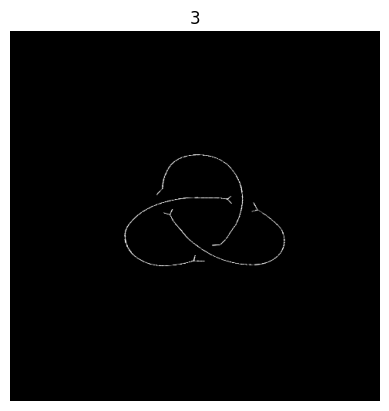

In [ ]:
# show a sample
import matplotlib.pyplot as plt

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(data.classes[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")
print(data.classes)

In [ ]:
# device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu" # cuda is MUCH faster
device

'cpu'

In [ ]:
# import requests
# from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

### Functions for models

In [ ]:
# aka training loop
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    y_pred_train, y_target_train = [], []
    for (X, y) in data_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X).squeeze(dim=1)

        for i in y_pred.tolist():
          y_pred_train.append(round(i))
        for i in y.tolist():
          y_target_train.append(round(i))

        # 2. Calculate loss
        loss = loss_fn(y_pred, y.type(torch.float32))
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.round()) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return y_pred_train, y_target_train, train_loss.cpu().detach().numpy(), train_acc

# aka testing loop
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              threshold: float = 0.001,
              device: torch.device = device,
              scheduler: torch.optim.lr_scheduler = None,
              save_path: str = None):
    test_loss, test_acc = 0, 0
    y_pred_test, y_target_test = [], []
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X).squeeze(dim=1)

            for i in test_pred.tolist():
              y_pred_test.append(round(i))
            for i in y.tolist():
              y_target_test.append(round(i))

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y.type(torch.float32))
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.round() # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        if scheduler != None:
          scheduler.step(test_loss)

        if test_acc > best_acc:
          best_fold = fold
          if save_path != None:
            torch.save(model.state_dict(), save_path + f'{model.__class__.__name__}_best.pth')

        print(f"\nTest loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return y_pred_test, y_target_test, test_loss.cpu().detach().numpy(), test_acc

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X).squeeze(dim=1)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.round())

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

### Functions for plotting

In [ ]:
te = torch.Tensor([[1., 2., 3., 4., 5., 6., 7., 8., 9.],
                   [1., 2., 3., 4., 5., 6., 7., 8., 9.],
                   [1., 2., 3., 4., 5., 6., 7., 8., 9.]])

te = torch.sum(te, dim=0)

siz_te = int(te.shape[0]**(1/2))

te = torch.unflatten(te, dim=0, sizes=(siz_te, siz_te))

# te, siz_te

In [ ]:
def plot_weights(layers: list):
  fig, axs = plt.subplots(ncols=1, nrows=len(layers), figsize=(7, 7*len(layers)))
  for i, layer in enumerate(layers):
    if type(layer) == torch.nn.modules.linear.Linear:
      weight = torch.sum(layer.weight, dim=0)
      siz = int(weight.shape[0]**(1/2))
      weight = torch.unflatten(weight, dim=0, sizes=(siz, siz))
    elif type(layer) == torch.nn.modules.conv.Conv2d:
      weight = torch.sum(torch.sum(layer.weight, dim=0), dim=0)
    axs[i].imshow(weight.cpu().detach().numpy())

In [ ]:
def plot_weights_image(layers: list, func_length: int, img: torch.Tensor):
  fig, axs = plt.subplots(ncols=2, nrows=func_length, figsize=(2*7, 7*func_length))
  i = -1
  for layer in layers:
    img = img.cpu()
    #print(type(layer), img.shape)
    if type(layer) == torch.nn.modules.linear.Linear:
      i += 1
      # how much does image activate each neuron
      img = img.squeeze()
      if torch.Tensor.dim(img) == 1:
        siz = int(img.shape[0]**(1/2))
        img = torch.unflatten(img, dim=0, sizes=(siz, siz))

      weight = torch.sum(layer.weight, dim=0).cpu()
      siz = int(weight.shape[0]**(1/2))
      weight = torch.unflatten(weight, dim=0, sizes=(siz, siz))
      mult = torch.mul(weight.cpu(), img.cpu()).cpu()
      axs[i][0].imshow(mult.detach().numpy())

      # output
      img = torch.flatten(img).unsqueeze(dim=0)
      img = layer(img.cuda()).cpu()

      siz = int(img.shape[1]**(1/2))
      img = torch.unflatten(img, dim=1, sizes=(siz, siz))

      axs[i][1].imshow(img.squeeze(dim=0).detach().numpy())

    elif type(layer) == torch.nn.modules.conv.Conv2d:
      i += 1
      weight = torch.sum(torch.sum(layer.weight, dim=0), dim=0)
      axs[i][0].imshow(weight.cpu().detach().numpy())

      img = layer(img.cuda()).cpu()

      img_show = torch.sum(img, dim=0)

      axs[i][1].imshow(img_show.squeeze(dim=0).detach().numpy())
    elif type(layer) == torch.nn.modules.flatten.Flatten:
      img = layer(img.unsqueeze(dim=0).cuda()).squeeze().cpu()
    elif type(layer) == torch.nn.modules.batchnorm.BatchNorm1d or type(layer) == torch.nn.modules.batchnorm.BatchNorm2d:
      pass
    else:
      img = layer(img.cuda()).cpu()

## Vanilla Model

In [ ]:
from torch import nn

# Create a model with non-linear and linear layers
class KnotsModelVanila(nn.Module):
    def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2: int, hidden_units_3:int, hidden_units_4: int, output_shape: int): # try to change the number of hidden layers
        super().__init__()
        self.dropout = nn.Dropout(p=0.9)

        self.layer_prepare = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_shape)
        )
        self.layer_1 = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units_1),
            nn.ELU(),
            nn.BatchNorm1d(hidden_units_1)
        )
        self.layer_2 = nn.Sequential(
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2),
            nn.ELU(),
            nn.BatchNorm1d(hidden_units_2)
        )
        self.layer_3 = nn.Sequential(
            nn.Linear(in_features=hidden_units_2, out_features=hidden_units_3),
            nn.ELU(),
            nn.BatchNorm1d(hidden_units_3)
        )
        self.layer_4 = nn.Sequential(
            nn.Linear(in_features=hidden_units_3, out_features=hidden_units_4),
            nn.ELU()
        )
        self.layer_5 = nn.Sequential(
            nn.Linear(in_features=hidden_units_4, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
      x = self.layer_prepare(x)
      #x = self.dropout(x)
      x = self.layer_1(x)
      #x = self.dropout(x)
      x = self.layer_2(x)
      #x = self.dropout(x)
      x = self.layer_3(x)
      #x = self.dropout(x)
      x = self.layer_4(x)
      x = self.dropout(x)
      x = self.layer_5(x)
      return x

In [ ]:
# let's try our model
from sklearn.model_selection import KFold #https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
from torch.utils.data import SubsetRandomSampler
from helper_functions import accuracy_fn

EPOCHS = 20
BATCH_SIZE = 64
N_SPLITS = 5
best_acc = 0
best_fold = 0
SAVE_PATH = 'content/saved_models'

try:
  os.mkdir(SAVE_PATH)
except:
  pass

train_losses, train_accuracies = [[] for i in range(N_SPLITS)], [[] for i in range(N_SPLITS)]
valid_losses, valid_accuracies = [[] for i in range(N_SPLITS)], [[] for i in range(N_SPLITS)]

y_pred_train, y_target_train = [[] for i in range(N_SPLITS)], [[] for i in range(N_SPLITS)]
y_pred_valid, y_target_valid = [[] for i in range(N_SPLITS)], [[] for i in range(N_SPLITS)]

kfold = KFold(n_splits=N_SPLITS, shuffle=True)

for fold, (train_idx, valid_idx) in tqdm.notebook.tqdm(enumerate(kfold.split(data))):
  print(f'Fold {fold+1}')
  print('--------------')

  train_dataloader = DataLoader(dataset=data,
                                batch_size=BATCH_SIZE,
                                sampler=SubsetRandomSampler(train_idx))

  valid_dataloader = DataLoader(dataset=data,
                                batch_size=BATCH_SIZE,
                                sampler=SubsetRandomSampler(valid_idx))


  model_1 = KnotsModelVanila(input_shape=IMG_SIZE**2,
                             hidden_units_1=22**2,
                             hidden_units_2=24**2,
                             hidden_units_3=14**2,
                             hidden_units_4=7**2,
                             output_shape=1
                            ).to(device)
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(params=model_1.parameters(),
                               lr=0.0003,
                               weight_decay=0.0001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=3,
                                                         threshold=0.001,
                                                         verbose=True)

  for epoch in tqdm.tqdm(range(EPOCHS)):
    print(f'\nEpoch: {epoch+1}')

    y_pred_train_fold, y_target_train_fold, train_loss, train_acc = train_step(data_loader=train_dataloader,
                                                                               model=model_1,
                                                                               loss_fn=loss_fn,
                                                                               optimizer=optimizer,
                                                                               accuracy_fn=accuracy_fn,
                                                                              )
    y_pred_train[fold] = y_pred_train_fold; y_target_train[fold] = y_target_train_fold
    train_losses[fold].append(train_loss); train_accuracies[fold].append(train_acc)

    y_pred_valid_fold, y_target_valid_fold, valid_loss, valid_acc = test_step(data_loader=valid_dataloader,
                                                                              model=model_1,
                                                                              loss_fn=loss_fn,
                                                                              accuracy_fn=accuracy_fn,
                                                                              scheduler=scheduler,
                                                                              save_path=SAVE_PATH
                                                                             )
    y_pred_valid[fold] = y_pred_valid_fold; y_target_valid[fold] = y_target_valid_fold
    valid_losses[fold].append(valid_loss); valid_accuracies[fold].append(valid_acc)

In [ ]:
model_1 = KnotsModelVanila(input_shape=IMG_SIZE**2,
                          hidden_units_1=22**2,
                          hidden_units_2=24**2,
                          hidden_units_3=14**2,
                          hidden_units_4=7**2,
                          output_shape=1
                        ).to(device)

model_1.load_state_dict(torch.load(SAVE_PATH + f'{model_1.__class__.__name__}_best.pth', weights_only=True))

In [ ]:
train_losses = train_losses[fold]; train_accuracies = train_accuracies[fold]
valid_losses = valid_losses[fold]; valid_accuracies = valid_accuracies[fold]
y_pred_train = y_pred_train[fold]; y_target_train = y_target_train[fold]
y_pred_valid = y_pred_valid[fold]; y_target_valid = y_target_valid[fold]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.title(f"Loss on {folder+1}th folder")

plt.plot(range(EPOCHS-3), train_losses[3:], label="Train", linewidth=2)
plt.plot(range(EPOCHS-3), valid_losses[3:], label="Validation", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.title("Accuracy")

plt.plot(range(epochs), train_accuracies, label="Train", linewidth=2)
plt.plot(range(epochs), valid_accuracies, label="Test", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

### Metrics

In [ ]:
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

In [ ]:
import sklearn.metrics

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
conf_matrix_train = sklearn.metrics.confusion_matrix(y_target_train, y_pred_train, labels=list(range(0, len(data.classes))))

conf_matrix_test = sklearn.metrics.confusion_matrix(y_target_valid, y_pred_valid, labels=list(range(0, len(data.classes))))

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1.set_title("Train")
ax2.set_title("Validation")

sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train).plot(ax=ax1)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix_valid).plot(ax=ax2)

### Weights

In [ ]:
KnotsModelVanila(
  (dropout): Dropout(p=0.9, inplace=False)
  (layer_prepare): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(262144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): Sequential(
    (0): Linear(in_features=262144, out_features=484, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(484, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): Linear(in_features=484, out_features=576, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Linear(in_features=576, out_features=196, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_4): Sequential(
    (0): Linear(in_features=196, out_features=49, bias=True)
    (1): ELU(alpha=1.0)
  )
  (layer_5): Sequential(
    (0): Linear(in_features=49, out_features=1, bias=True)
  )
)

In [ ]:
plot_weights([model_1.layer_1[0], model_1.layer_2[0], model_1.layer_3[0], model_1.layer_4[0], model_1.layer_5[0]])

In [ ]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img = train_features_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis("Off")

In [ ]:
plot_weights_image([model_1.layer_1[0], model_1.layer_2[0], model_1.layer_3[0], model_1.layer_4[0], model_1.layer_5[0]], 5, img)

### Evaluate and save

In [ ]:
# Calculate model_1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device
                         )
model_1_results

In [ ]:
# Instantiate a fresh instance of KnotsModelVanila
loaded_model_1 = KnotsModelVanila(
    input_shape=IMG_SIZE**2, # number of input features
    hidden_units_1=22**2,
    hidden_units_2=24**2,
    hidden_units_3=14**2,
    hidden_units_4=7**2,
    output_shape=1 # number of output classes desired
).to(device) # send model to GPU if it's available
next(loaded_model_1.parameters()).device # check model device

# Load model state dict
loaded_model_1.load_state_dict(torch.load(Path("models/Vanilla.pth")))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

In [ ]:
model_1 = loaded_model_1

In [ ]:
model_1_loaded_results = eval_model(model=loaded_model_1, data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device
                         )
model_1_loaded_results

## CNN

In [ ]:
from torch import nn

# Create a convolutional neural network
class KnotsModelCNN(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/

    To understand how it works, I highly recommend you go through the 'Convolutional Neural Networks' section at https://colah.github.io/ (of course, the other articles are very good too, so it's best to read them all!)
    """
    def __init__(self, hidden_units_conv: int, hidden_units_fc: int, output_shape: int):
        super().__init__()
ValueError: Unsupported nprocs (8). Please use nprocs=1 or None (default). If None, spawn will use all available devices. Use the environment variable
        self.conv = nn.Sequential(
          # layer_1
          nn.Conv2d(1, hidden_units_conv**2, kernel_size=15, stride=1, padding=1),
          nn.BatchNorm2d(hidden_units_conv**2),
          nn.ReLU(),

          nn.Conv2d(hidden_units_conv**2, hidden_units_conv**2, kernel_size=11, stride=1, padding=1),
          nn.BatchNorm2d(hidden_units_conv**2),
          nn.ReLU(),

          nn.MaxPool2d(kernel_size=4, stride=2),

          #layer_2
          nn.Conv2d(hidden_units_conv**2, (hidden_units_conv+2)**2, kernel_size=5, stride=1, padding=1),
          nn.BatchNorm2d((hidden_units_conv+2)**2),
          nn.ReLU(),

          nn.Conv2d((hidden_units_conv+2)**2, (hidden_units_conv+2)**2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d((hidden_units_conv+2)**2),
          nn.ReLU(),

          nn.MaxPool2d(kernel_size=2, stride=2),

          #layer_3
          nn.Conv2d((hidden_units_conv+2)**2, (hidden_units_conv+4)**2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d((hidden_units_conv+4)**2),
          nn.ReLU(),

          nn.Conv2d((hidden_units_conv+4)**2, (hidden_units_conv+4)**2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d((hidden_units_conv+4)**2),
          nn.ReLU(),

          nn.Conv2d((hidden_units_conv+4)**2, (hidden_units_conv+4)**2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d((hidden_units_conv+4)**2),
          nn.ReLU(),

          nn.MaxPool2d(kernel_size=2, stride=2),

          #layer_4
          nn.Conv2d((hidden_units_conv+4)**2, (hidden_units_conv+5)**2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d((hidden_units_conv+5)**2),
          nn.ReLU(),

          nn.Conv2d((hidden_units_conv+5)**2, (hidden_units_conv+5)**2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d((hidden_units_conv+5)**2),
          nn.ReLU(),

          nn.Conv2d((hidden_units_conv+5)**2, (hidden_units_conv+5)**2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d((hidden_units_conv+5)**2),
          nn.ReLU(),

          nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d((hidden_units_conv+5)**2*(30)**2),

            nn.Dropout(0.5),
            nn.Linear(in_features=(hidden_units_conv+5)**2*(30)**2,
                      out_features=hidden_units_fc),
            nn.ELU(),

            nn.Linear(in_features=hidden_units_fc,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [ ]:
model_2 = KnotsModelCNN(hidden_units_conv=5,
                        hidden_units_fc=1024,
                        output_shape=1
                        ).to(device)

In [ ]:
model_2(train_features_batch.to(device))

In [ ]:
param_size = 0
for param in model_2.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_2.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                              lr=0.0003,
                              weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='min',
                                                        factor=0.2,
                                                        patience=7,
                                                        threshold=0.001,
                                                        verbose=True)

for i in range(20):
  train_step(model_2,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device)

In [ ]:
# let's try our model
from sklearn.model_selection import KFold #https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
from torch.utils.data import SubsetRandomSampler
from helper_functions import accuracy_fn

EPOCHS = 5
BATCH_SIZE = 64
N_SPLITS = 2
best_acc = 0
best_fold = 0
SAVE_PATH = 'content/saved_models'

try:
  os.mkdir(SAVE_PATH)
except:
  pass

train_losses, train_accuracies = [[] for i in range(N_SPLITS)], [[] for i in range(N_SPLITS)]
valid_losses, valid_accuracies = [[] for i in range(N_SPLITS)], [[] for i in range(N_SPLITS)]

y_pred_train, y_target_train = [[] for i in range(N_SPLITS)], [[] for i in range(N_SPLITS)]
y_pred_valid, y_target_valid = [[] for i in range(N_SPLITS)], [[] for i in range(N_SPLITS)]

kfold = KFold(n_splits=N_SPLITS, shuffle=True)

for fold, (train_idx, valid_idx) in tqdmn(enumerate(kfold.split(data))):
  print(f'Fold {fold+1}')
  print('--------------')

  train_dataloader = DataLoader(dataset=data,
                                batch_size=BATCH_SIZE,
                                sampler=SubsetRandomSampler(train_idx),
                                num_workers=2,
                                pin_memory=True)

  valid_dataloader = DataLoader(dataset=data,
                                batch_size=BATCH_SIZE,
                                sampler=SubsetRandomSampler(valid_idx),
                                num_workers=2,
                                pin_memory=True)

  model_2 = KnotsModelCNN(hidden_units_fc=1024,
                          output_shape=1
                         ).to(device)
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(params=model_2.parameters(),
                               lr=0.0003,
                               weight_decay=0.0001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=7,
                                                         threshold=0.001,
                                                         verbose=True)

  for epoch in tqdm.tqdm(range(EPOCHS)):
    print(f'\nEpoch: {epoch+1}')

    y_pred_train_fold, y_target_train_fold, train_loss, train_acc = train_step(data_loader=train_dataloader,
                                                                               model=model_2,
                                                                               loss_fn=loss_fn,
                                                                               optimizer=optimizer,
                                                                               accuracy_fn=accuracy_fn,
                                                                              )
    y_pred_train[fold] = y_pred_train_fold; y_target_train[fold] = y_target_train_fold
    train_losses[fold].append(train_loss); train_accuracies[fold].append(train_acc)

    y_pred_valid_fold, y_target_valid_fold, valid_loss, valid_acc = test_step(data_loader=valid_dataloader,
                                                                              model=model_2,
                                                                              loss_fn=loss_fn,
                                                                              accuracy_fn=accuracy_fn,
                                                                              scheduler=scheduler,
                                                                              save_path=SAVE_PATH
                                                                             )
    y_pred_valid[fold] = y_pred_valid_fold; y_target_valid[fold] = y_target_valid_fold
    valid_losses[fold].append(valid_loss); valid_accuracies[fold].append(valid_acc)

In [ ]:
model_2 = KnotsModelCNN(hidden_units_fc=1024,
                        output_shape=len(data.classes)
                       ).to(device)

model_2.load_state_dict(torch.load(SAVE_PATH + f'{model_2.__class__.__name__}_best.pth', weights_only=True))

In [ ]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

# count_parameters(model_2)

In [ ]:
train_losses = train_losses[fold]; train_accuracies = train_accuracies[fold]
valid_losses = valid_losses[fold]; valid_accuracies = valid_accuracies[fold]
y_pred_train = y_pred_train[fold]; y_target_train = y_target_train[fold]
y_pred_valid = y_pred_valid[fold]; y_target_valid = y_target_valid[fold]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.title(f"Loss on {folder+1}th folder")

plt.plot(range(EPOCHS-3), train_losses[3:], label="Train", linewidth=2)
plt.plot(range(EPOCHS-3), valid_losses[3:], label="Validation", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.title("Accuracy")

plt.plot(range(epochs), train_accuracies, label="Train", linewidth=2)
plt.plot(range(epochs), valid_accuracies, label="Test", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

### Metrics

In [ ]:
conf_matrix_train = sklearn.metrics.confusion_matrix(y_target_train, y_pred_train, labels=list(range(0, len(data.classes))))

# conf_matrix_train

conf_matrix_test = sklearn.metrics.confusion_matrix(y_target_valid, y_pred_valid, labels=list(range(0, len(data.classes))))

# conf_matrix_valid

conf_matrix_test = sklearn.metrics.confusion_matrix(y_target_valid, y_pred_valid, labels=list(range(0, len(data.classes))))

conf_matrix_valid

### Weights

In [ ]:
model_2

plot_weights([model_2.block_1[0], model_2.block_1[4], model_2.block_1[8], model_2.block_1[11], model_2.block_1[14], model_2.classifier[3], model_2.classifier[7], model_2.classifier[9]])

In [ ]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img = train_features_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis("Off")

In [ ]:
func = []
to_be_shown = (torch.nn.modules.linear.Linear, torch.nn.modules.Conv2d)
func_l = 0

for name, module in model_2.named_modules():
  l = len(name.split('.'))
  if l >= 2:
    func.append(module)
    if type(module) in to_be_shown:
      func_l += 1

func, func_l

In [ ]:
plot_weights_image(func, func_l, img)

### Evaluate and save

In [ ]:
# Calculate model_1 results with device-agnostic code
model_2_results = eval_model(model=model_2, data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device
                         )
model_2_results

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

In [ ]:
# Instantiate a fresh instance of KnotsModelVanila
loaded_model_2 = KnotsModelCNN(
                        input_channels_shape=1,
                        input_image_shape=IMG_SIZE**2,
                        hidden_units_conv=16,
                        hidden_units_fc=4096,
                        output_shape=1
                        ).to(device) # send model to GPU if it's available
next(loaded_model_2.parameters()).device # check model device

# Load model state dict
loaded_model_2.load_state_dict(torch.load(Path("models/CNN.pth")))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_2.to(device)

print(f"Loaded model:\n{loaded_model_2}")
print(f"Model on device:\n{next(loaded_model_2.parameters()).device}")

In [ ]:
model_2 = loaded_model_2

model_2_loaded_results = eval_model(model=loaded_model_2, data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device
                         )
model_2_loaded_results

## Rating the models

In [ ]:
shutil.rmtree('./content')

# extract .zip
try:
  shutil.rmtree("/content/test_knots")
except Exception as e:
  pass

# get all .zip files from local storage
files = glob.glob('*.zip')

# if 2 or more files occured, we don't know which we want to extract
if len(files) > 1:
  print("Don't know which archive to unpack")
else:
  # unpack .zip
  with zipfile.ZipFile(f"/content/{files[0]}","r") as zip_ref:
      zip_ref.extractall("/content")

In [ ]:
# we use torchvision.datasets.ImageFolder class to divide our data into classes and work with them efficiently
# useful links: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
#
#               https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

data_transform = v2.Compose([v2.Grayscale(num_output_channels=1),
                             v2.ToImage(),
                             v2.ToDtype(torch.float32, scale=True),
                             v2.functional.invert])



valid_data = CustomImageFolder(root='/content/content/test_knots_512',
                         transform=data_transform)

valid_dataloader = DataLoader(valid_data)

eval_model(model=model_2, data_loader=valid_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

## TODO

- [ ] Revise `requirements.txt` to include:
   - torch
   - numpy
   - pillow
   - cairosvg